# LSTM classification
* support kaggle, tpu, local
* support wandb
* restart

In [1]:
import wandb
from wandb.keras import WandbCallback
wandb_api = "f571af2e972ca3d32084ed1f08cdb30a7c49321e" #user_secrets.get_secret("wandb_api")
wandb.login(key=wandb_api)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yamsam. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/isamu/.netrc


True

In [2]:
import os
IS_COLAB = not os.path.exists('/kaggle/input') and not os.path.exists('/home/isamu') 
print('COLAB', IS_COLAB) 
IS_KAGGLE = os.path.exists('/kaggle/input')
print('KAGGLE', IS_KAGGLE) 

COLAB False
KAGGLE False


In [3]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

def auto_select_accelerator():
    TPU_DETECTED = False
    MIXED = False
    try:
        if MIXED:
          tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
          tf.config.experimental_connect_to_cluster(tpu)
          tf.tpu.experimental.initialize_tpu_system(tpu)
          strategy = tf.distribute.experimental.TPUStrategy(tpu)
          policy = mixed_precision.Policy('mixed_bfloat16')
          mixed_precision.set_global_policy(policy)
          tf.config.optimizer.set_jit(True)
        else:
          tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
          tf.config.experimental_connect_to_cluster(tpu)
          tf.tpu.experimental.initialize_tpu_system(tpu)
          strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
        TPU_DETECTED = True
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    return strategy, TPU_DETECTED

strategy, tpu_detected = auto_select_accelerator()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

Running on 1 replicas


In [4]:
# Data I/O and preprocessing
import numpy as np
import wandb

# System
import time
import os
import gc
import math
import random
import re
from datetime import datetime
import tensorflow as tf
#import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import mixed_precision
# Graphic
import matplotlib.pyplot as plt

from tqdm import tqdm

#from kaggle_datasets import KaggleDatasets
%matplotlib inline

In [5]:
if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-02-19 17:30:00.856339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 17:30:00.861171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 17:30:00.861340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 17:30:00.862175: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

# Global Setting

In [7]:
class config:
    GROUP_NAME='lstm'
    EXP_NAME='test'
    
    # data
    BIN_NUM = 16
    # model
    MAX_PULSE_COUNT = 128
    SHUFFLE_SIZE = 4096 # 1024

    LSTM_width = 160
    DENSE_width = 0
    N_COLS = 9

    BATCH_SIZE = 2048 * REPLICAS
    MIXED=False

    LR_START = 1e-2
    LR_MAX = 1e-2
    LR_MIN = 1e-6
    LR_RAMPUP_EPOCHS = 0
    LR_SUSTAIN_EPOCHS = 0
    STEPS = [160, 240, 600]

    EPOCHS = 1 #20
    LR = 1e-3 #1e-3

    SEED=136

    NOT_WATCH_PARAM = ['']
    

filenames = ["rsna-cls-15" ]

run_ts = datetime.now().strftime('%Y%m%d-%H%M%S')

PI =  3.14159

# TPU
if not tpu_detected:
    REPLICAS=1
    
INPUT='../input/'
if IS_COLAB:
    exp_dir=f"/content/drive/MyDrive/Colab Notebooks/ICECUBE/{EXP_NAME}"
    !mkdir  "{exp_dir}"
    save_dir = f"/content/drive/MyDrive/Colab Notebooks/ICECUBE/{EXP_NAME}/{run_ts}/"
    !mkdir  "{save_dir}"
    INPUT='input/'
else:
    save_dir = "./"

In [8]:
gcs_paths = []

#filenames = ['gs://kds-14a3ba81d592f3770489039cb02d9c5b350b9c23abea52f32fe4cf6a', 'gs://kds-c0c636f72ddce59d80b93e216dcdaa971a17f62bac97449eb70dba34', 'gs://kds-325e5a90a11592fbff3f8ff860278bf8a507431d03fe4c17adeab9e9', 'gs://kds-c04df881a8fa5b5e0f7ca94be00b87f4149708d377fce3c6ed9cfabc', 'gs://kds-c812038542d133d118004ad02dec890775a277538d66ae2e4dad8f39']
# -150
#filenames = ['gs://kds-c0c636f72ddce59d80b93e216dcdaa971a17f62bac97449eb70dba34', 'gs://kds-325e5a90a11592fbff3f8ff860278bf8a507431d03fe4c17adeab9e9', 'gs://kds-c04df881a8fa5b5e0f7ca94be00b87f4149708d377fce3c6ed9cfabc', 'gs://kds-c812038542d133d118004ad02dec890775a277538d66ae2e4dad8f39', 'gs://kds-166f90ce98ca943907860bac6967f55870ac621f2a4a450fbfda531f', 'gs://kds-98cfd524969df7cd64c47b722aad9ddeeee42f54ae184d092af166a7', 'gs://kds-1526b280fd811fae878fdd5ec2034d68a00ddb710bcecd1f1b8a69e0', 'gs://kds-5d9282028e0a9ad1e1f3248407414931bac502afac67e8dc4cfea9e6', 'gs://kds-5dff1394e81dd96307654883ebb571f7c3add9f3914570fb24f552d9', 'gs://kds-14a3ba81d592f3770489039cb02d9c5b350b9c23abea52f32fe4cf6a']

# if IS_KAGGLE:
#     from kaggle_datasets import KaggleDatasets
#     for f in filenames:
#         GCS_path = KaggleDatasets().get_gcs_path(f)
#         gcs_paths.append(GCS_path)

#     print(gcs_paths)

if IS_COLAB or IS_KAGGLE:
    for f in filenames:
        gcs_paths.append(f)
        
else:
    for f in filenames:
        gcs_paths.append(f'../../input/{f}')

In [9]:
!

In [10]:
gcs_paths

['../../input/rsna-cls-15']

In [11]:
fold_files = []
for path in gcs_paths:
    folds = tf.io.gfile.glob(path + f"/*.tfrec")
    fold_files += folds

    print(f"train_files fold: ", len(fold_files))

train_files fold:  15


In [12]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(config.SEED)

In [13]:
import re
def read_labeled_tfrecord(example):
    
    LABELED_TFREC_FORMAT = {
      "x":tf.io.FixedLenFeature([config.N_COLS*config.MAX_PULSE_COUNT], tf.float32),
      "y":tf.io.FixedLenFeature([config.BIN_NUM*config.BIN_NUM], tf.float32),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    x = tf.reshape(example['x'], (config.MAX_PULSE_COUNT, -1))
    y = example['y']

    return x, y

def preprocess(x,y):
    #x = x[:,0].assign(x[:,0]/1000)
    
    x2 = tf.stack([x[:,0] / 1000,
                   x[:,1] / 300,
                   x[:,2],
                   x[:,3] / 600,
                   x[:,4] / 600,
                   x[:,5] / 600,
                   x[:,6] / 600,
                   x[:,7] / 600,
                   x[:,8] / 600,
                 ],axis=1)

    return x2, y
    

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    
    dataset = dataset.map(lambda x, y: preprocess(x, y), num_parallel_calls=AUTO)
    # returns a dataset of (image,Ilabel) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset(filenames, batch_size):
    dataset = load_dataset(filenames, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(config.SHUFFLE_SIZE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset


def get_valid_dataset(filenames, batch_size):
    dataset = load_dataset(filenames, labeled=True)
    dataset = dataset.batch(batch_size)
#    dataset = dataset.repeat(None)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset


def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


# Prepare Metric

In [14]:
azimuth_edges = np.linspace(0, 2 * np.pi, config.BIN_NUM + 1)
zenith_edges_flat = np.linspace(0, np.pi, config.BIN_NUM + 1)
zenith_edges = list()
zenith_edges.append(0)
for bin_idx in range(1, config.BIN_NUM):
    # cos(zen_before) - cos(zen_now) = 2 / config.BIN_NUM
    zen_now = np.arccos(np.cos(zenith_edges[-1]) - 2 / (config.BIN_NUM))
    zenith_edges.append(zen_now)
zenith_edges.append(np.pi)
zenith_edges = np.array(zenith_edges)

## Scoring functions

In [15]:
def angular_dist_score(az_true, zen_true, az_pred, zen_pred):
    '''
    calculate the MAE of the angular distance between two directions.
    The two vectors are first converted to cartesian unit vectors,
    and then their scalar product is computed, which is equal to
    the cosine of the angle between the two vectors. The inverse 
    cosine (arccos) thereof is then the angle between the two input vectors
    
    Parameters:
    -----------
    
    az_true : float (or array thereof)
        true azimuth value(s) in radian
    zen_true : float (or array thereof)
        true zenith value(s) in radian
    az_pred : float (or array thereof)
        predicted azimuth value(s) in radian
    zen_pred : float (or array thereof)
        predicted zenith value(s) in radian
    
    Returns:
    --------
    
    dist : float
        mean over the angular distance(s) in radian
    '''
    
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    
    # pre-compute all sine and cosine values
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)
    
    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)
    
    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    
    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =  np.clip(scalar_prod, -1, 1)
    
    # convert back to an angle (in radian)
    return np.average(np.abs(np.arccos(scalar_prod)))

## Angle One-hot Encoding

- azimuth and zenith are independent
- azimuth distribution is flat and zenith distribution is sin
  - Flat on the spherical surface
  - $\phi > \pi$ events are a little bit rarer than $\phi < \pi$ events, (maybe) because of the neutrino attenuation by earth.
- So, the uniform bin is used for azimuth, and $\left| \cos \right|$ bin is used for zenith

In [16]:
def y_to_onehot(batch_y):
    # evaluate bin code
    azimuth_code = (batch_y[:, 0] > azimuth_edges[1:].reshape((-1, 1))).sum(axis=0)
    zenith_code = (batch_y[:, 1] > zenith_edges[1:].reshape((-1, 1))).sum(axis=0)
    angle_code = config.BIN_NUM * azimuth_code + zenith_code

    # one-hot
    batch_y_onehot = np.zeros((angle_code.size, config.BIN_NUM * config.BIN_NUM))
    batch_y_onehot[np.arange(angle_code.size), angle_code] = 1
    
    return batch_y_onehot

In [17]:
angle_bin_zenith0 = np.tile(zenith_edges[:-1], config.BIN_NUM)
angle_bin_zenith1 = np.tile(zenith_edges[1:], config.BIN_NUM)
angle_bin_azimuth0 = np.repeat(azimuth_edges[:-1], config.BIN_NUM)
angle_bin_azimuth1 = np.repeat(azimuth_edges[1:], config.BIN_NUM)

angle_bin_area = (angle_bin_azimuth1 - angle_bin_azimuth0) * (np.cos(angle_bin_zenith0) - np.cos(angle_bin_zenith1))
angle_bin_vector_sum_x = (np.sin(angle_bin_azimuth1) - np.sin(angle_bin_azimuth0)) * ((angle_bin_zenith1 - angle_bin_zenith0) / 2 - (np.sin(2 * angle_bin_zenith1) - np.sin(2 * angle_bin_zenith0)) / 4)
angle_bin_vector_sum_y = (np.cos(angle_bin_azimuth0) - np.cos(angle_bin_azimuth1)) * ((angle_bin_zenith1 - angle_bin_zenith0) / 2 - (np.sin(2 * angle_bin_zenith1) - np.sin(2 * angle_bin_zenith0)) / 4)
angle_bin_vector_sum_z = (angle_bin_azimuth1 - angle_bin_azimuth0) * ((np.cos(2 * angle_bin_zenith0) - np.cos(2 * angle_bin_zenith1)) / 4)

angle_bin_vector_mean_x = angle_bin_vector_sum_x / angle_bin_area
angle_bin_vector_mean_y = angle_bin_vector_sum_y / angle_bin_area
angle_bin_vector_mean_z = angle_bin_vector_sum_z / angle_bin_area

angle_bin_vector = np.zeros((1, config.BIN_NUM * config.BIN_NUM, 3))
angle_bin_vector[:, :, 0] = angle_bin_vector_mean_x
angle_bin_vector[:, :, 1] = angle_bin_vector_mean_y
angle_bin_vector[:, :, 2] = angle_bin_vector_mean_z

def pred_to_angle(pred, epsilon=1e-8):
    # convert prediction to vector
    pred_vector = (pred.reshape((-1, config.BIN_NUM * config.BIN_NUM, 1)) * angle_bin_vector).sum(axis=1)
    
    # normalize
    pred_vector_norm = np.sqrt((pred_vector**2).sum(axis=1))
    mask = pred_vector_norm < epsilon
    pred_vector_norm[mask] = 1
    
    # assign <1, 0, 0> to very small vectors (badly predicted)
    pred_vector /= pred_vector_norm.reshape((-1, 1))
    pred_vector[mask] = np.array([1., 0., 0.])
    
    # convert to angle
    azimuth = np.arctan2(pred_vector[:, 1], pred_vector[:, 0])
    azimuth[azimuth < 0] += 2 * np.pi
    zenith = np.arccos(pred_vector[:, 2])
    
    return azimuth, zenith

# feature engineering

## Split validation samples

In [18]:
if len(fold_files) < 10:
    files_train = fold_files[:4]
    files_valid = fold_files[4:]
else:
    n_valid = 2 #int(len(fold_files) / 10)
    files_train = fold_files[:-n_valid]
    files_valid = fold_files[-n_valid:]
    
print (len(files_train), len(files_valid))

13 2


## hyperparameters for LSTM model

## Define & Train Model

In [19]:
print(" config.LSTM_width : ", config.LSTM_width)
print("config.DENSE_width : ", config.DENSE_width)

 config.LSTM_width :  160
config.DENSE_width :  0


Learning rate schedule: 0.01 to 0.01 to 0.01


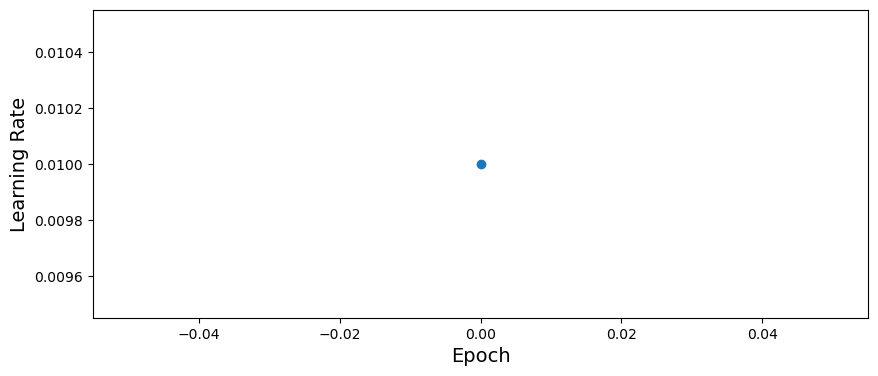

In [20]:
import math 
import matplotlib.pyplot as plt



def lrfn(epoch):
    if epoch<config.STEPS[0]:
        epoch2 = epoch
        EPOCHS2 = config.STEPS[0]
    elif epoch<config.STEPS[0]+config.STEPS[1]:
        epoch2 = epoch-config.STEPS[0]
        EPOCHS2 = config.STEPS[1]
    elif epoch<config.STEPS[0]+config.STEPS[1]+config.STEPS[2]:
        epoch2 = epoch-config.STEPS[0]-config.STEPS[1]
        EPOCHS2 = config.STEPS[2]
    
    if epoch2 < config.LR_RAMPUP_EPOCHS:
        lr = (config.LR_MAX - config.LR_START) / config.LR_RAMPUP_EPOCHS * epoch2 + config.LR_START
    elif epoch2 < config.LR_RAMPUP_EPOCHS + config.LR_SUSTAIN_EPOCHS:
        lr = config.LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - config.LR_RAMPUP_EPOCHS - config.LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch2 - config.LR_RAMPUP_EPOCHS - config.LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (config.LR_MAX - config.LR_MIN) * cosine_decay + config.LR_MIN
    return lr

rng = [i for i in range(config.EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
          format(lr_y[0], max(lr_y), lr_y[-1]))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
plt.xlabel('Epoch',size=14)
plt.ylabel('Learning Rate',size=14)
plt.show()

In [21]:

with strategy.scope():
    # build model
    model_inputs = tf.keras.layers.Input((config.MAX_PULSE_COUNT, config.N_COLS))
    model_x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.LSTM_width))(model_inputs)
    model_x = tf.keras.layers.LayerNormalization()(model_x)
    #model_x = tf.keras.layers.Dense(config.DENSE_width, activation='relu')(model_x)
    #model_outputs = tf.keras.layers.Dense(2, activation='sigmoid')(model_x)
    model_outputs = tf.keras.layers.Dense(config.BIN_NUM * config.BIN_NUM, activation='softmax')(model_x)

    model = tf.keras.Model(
        inputs=model_inputs,
        outputs=model_outputs,
        name="model"
    )
    # compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)
    #loss = tf.keras.losses.Huber() 

    loss = 'categorical_crossentropy'
    metrics = ['accuracy']

    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics
    )

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 320)              217600    
 l)                                                              
                                                                 
 layer_normalization (LayerN  (None, 320)              640       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               82176     
                                                                 
Total params: 300,416
Trainable params: 300,416
Non-trainable params: 0
_________________________________________________________________


In [22]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from wandb.keras import WandbCallback
# EaelyStoppingの設定
early_stopping =  EarlyStopping(
                            monitor='val_loss',
                            patience=100,
)

train_image_count = count_data_items(files_train) 

print (train_image_count)

ds_train = get_training_dataset(files_train, config.BATCH_SIZE)

ds_valid = get_valid_dataset(files_valid, config.BATCH_SIZE)

if tpu_detected:
    steps_per_epoch=train_image_count // config.BATCH_SIZE
else:
    steps_per_epoch=train_image_count // config.BATCH_SIZE 

model_ckpt = tf.keras.callbacks.ModelCheckpoint(    
    save_dir+f"/best_model.h5",
     monitor="val_accuracy", verbose=1, save_best_only=True,
    save_weights_only=True, mode="max", save_freq="epoch"
)

log_filepath = 'log'
#tb_cb = tf.keras.callbacks.TensorBoard(log_dir=log_filepath, histogram_freq=1)


wandb.init(project='ICECUBE', entity='yamsam', name=config.EXP_NAME, group=config.GROUP_NAME)

for k, v in dict(vars(config)).items():
    if k[:2] == "__" or k in config.NOT_WATCH_PARAM:
        continue
    print (k, v)
    wandb.config[k] = v

#wandb_config.fold = fold
#wandb.watch(model)

history = model.fit(
    ds_train,
    epochs=config.EPOCHS,
    callbacks=[model_ckpt, lr_callback, WandbCallback()],
#    callbacks=[model_ckpt, lr_callback, tb_cb],
    steps_per_epoch=steps_per_epoch,
    validation_data=ds_valid,
    verbose=True
)
model.save_weights(save_dir+f'last_model.h5')

2600000


/home/isamu/workdata/anaconda3/envs/tf2.6/lib/python3.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


GROUP_NAME lstm
EXP_NAME test
BIN_NUM 16
MAX_PULSE_COUNT 128
SHUFFLE_SIZE 4096
LSTM_width 160
DENSE_width 0
N_COLS 9
BATCH_SIZE 2048
MIXED False
LR_START 0.01
LR_MAX 0.01
LR_MIN 1e-06
LR_RAMPUP_EPOCHS 0
LR_SUSTAIN_EPOCHS 0
STEPS [160, 240, 600]
EPOCHS 1
LR 0.001
SEED 136
NOT_WATCH_PARAM ['']

Epoch 1: LearningRateScheduler setting learning rate to 0.01.


2023-02-19 17:30:14.162624: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


   2/1269 [..............................] - ETA: 1:06 - loss: 6.2507 - accuracy: 0.0037   

2023-02-19 17:30:14.874203: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1269/1269 [==============================] - ETA: 0s - loss: 5.4667 - accuracy: 0.0097
Epoch 1: val_accuracy improved from -inf to 0.03774, saving model to ./best_model.h5


INFO:tensorflow:Assets written to: /mnt/workdata/kaggle/ICECUBE/notebooks/baseline/wandb/run-20230219_173002-qb3vkwnx/files/model-best/assets


INFO:tensorflow:Assets written to: /mnt/workdata/kaggle/ICECUBE/notebooks/baseline/wandb/run-20230219_173002-qb3vkwnx/files/model-best/assets
wandb: Adding directory to artifact (/mnt/workdata/kaggle/ICECUBE/notebooks/baseline/wandb/run-20230219_173002-qb3vkwnx/files/model-best)... Done. 0.1s


1269/1269 [==============================] - 81s 61ms/step - loss: 5.4667 - accuracy: 0.0097 - val_loss: 5.1132 - val_accuracy: 0.0377 - lr: 0.0100


## Draw training progress

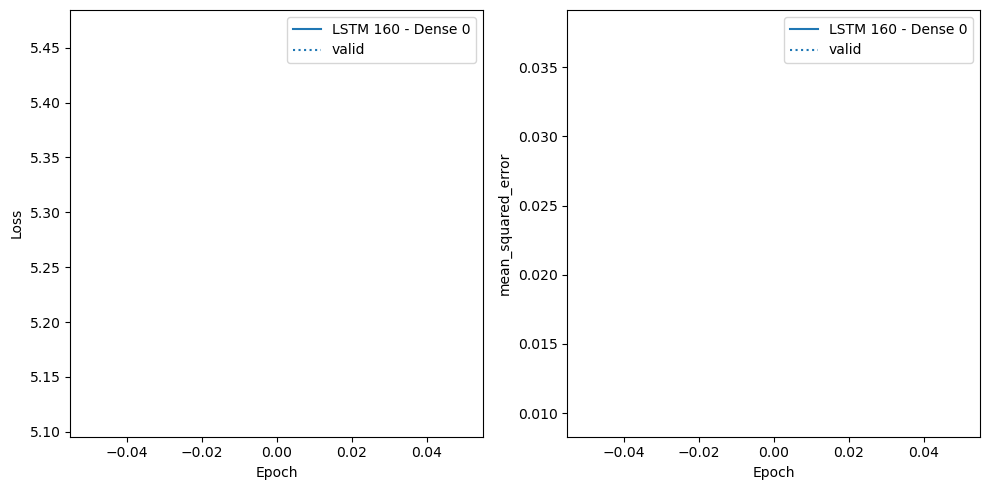

In [23]:
fig = plt.figure(figsize=(10, 5))

label = f"LSTM {config.LSTM_width:d} - Dense {config.DENSE_width:d}"

# history - loss
ax = plt.subplot(121)
line = ax.plot(history.epoch, history.history['loss'], label=label)
ax.plot(history.epoch, history.history['val_loss'], linestyle="dotted", color=line[0].get_color(), label="valid")
#ax.axhline(np.log(config.BIN_NUM * config.BIN_NUM), color="gray", label="random")

ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend()

# history - accuracy
ax = plt.subplot(122)
line = ax.plot(history.epoch, history.history['accuracy'], label=label)
ax.plot(history.epoch, history.history['val_accuracy'], linestyle="dotted", color=line[0].get_color(), label="valid")
#ax.axhline(1 / config.BIN_NUM / config.BIN_NUM, color="gray", label="random")

ax.set_ylabel("mean_squared_error")
ax.set_xlabel("Epoch")
ax.legend()

plt.tight_layout()
plt.show()


fig.savefig("history.jpg")

wandb.log(
    {"history_image":wandb.Image("history.jpg")})

## Evaluate model

In [24]:
ds_valid = get_valid_dataset(files_valid[0], config.BATCH_SIZE)

def batch_to_numpy(data):
    x, y = data
    x = x.numpy()
    y = y.numpy()
    return x, y
    
valid_y = []
for data in ds_valid:
    x, y = batch_to_numpy(data)
    valid_y.append(y)
    
valid_y = np.vstack(valid_y)

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
model.load_weights(save_dir+'best_model.h5')

valid_pred = model.predict(ds_valid, verbose=1)

valid_pred_azimuth, valid_pred_zenith  = pred_to_angle(valid_pred)

gt_azimuth, gt_zenith = pred_to_angle(valid_y)

mae = angular_dist_score(gt_azimuth, gt_zenith, valid_pred_azimuth, valid_pred_zenith)

acc = accuracy_score(np.argmax(valid_y,axis=1), np.argmax(valid_pred,axis=1))


98/98 [==============================] - 3s 29ms/step


In [27]:
print ('last acc', acc)
print ('best', mae)

wandb.log({
            "best_mae": mae,
        })


last acc 0.03753
best 1.2157766315859644


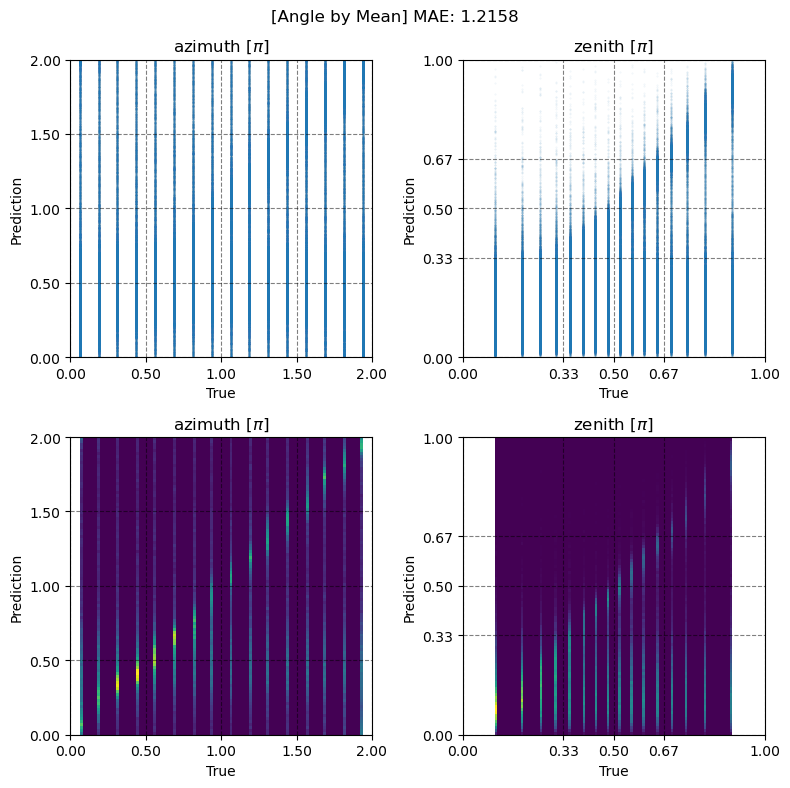

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

ax = axs[0, 0]
ax.scatter(gt_azimuth, valid_pred_azimuth, s=0.1, alpha=0.1)
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.set_xlim(0, 2 * np.pi)
ax.set_ylim(0, 2 * np.pi)
ax.set_xticks(azimuth_edges[0::(config.BIN_NUM//4)])
ax.set_xticklabels(["%.2f" % n for n in azimuth_edges[0::(config.BIN_NUM//4)] / np.pi])
ax.set_yticks(azimuth_edges[0::(config.BIN_NUM//4)])
ax.set_yticklabels(["%.2f" % n for n in azimuth_edges[0::(config.BIN_NUM//4)] / np.pi])
ax.grid(linestyle="dashed", color="black", alpha=0.5)
ax.set_title(r"azimuth [$\pi$]")

ax = axs[0, 1]
ax.scatter(gt_zenith, valid_pred_zenith, s=0.1, alpha=0.1)
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
ax.set_xticks(zenith_edges[0::(config.BIN_NUM//4)])
ax.set_xticklabels(["%.2f" % n for n in zenith_edges[0::(config.BIN_NUM//4)] / np.pi])
ax.set_yticks(zenith_edges[0::(config.BIN_NUM//4)])
ax.set_yticklabels(["%.2f" % n for n in zenith_edges[0::(config.BIN_NUM//4)] / np.pi])
ax.grid(linestyle="dashed", color="black", alpha=0.5)
ax.set_title(r"zenith [$\pi$]")

ax = axs[1, 0]
ax.hist2d(gt_azimuth, valid_pred_azimuth, bins=100)
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.set_xlim(0, 2 * np.pi)
ax.set_ylim(0, 2 * np.pi)
ax.set_xticks(azimuth_edges[0::(config.BIN_NUM//4)])
ax.set_xticklabels(["%.2f" % n for n in azimuth_edges[0::(config.BIN_NUM//4)] / np.pi])
ax.set_yticks(azimuth_edges[0::(config.BIN_NUM//4)])
ax.set_yticklabels(["%.2f" % n for n in azimuth_edges[0::(config.BIN_NUM//4)] / np.pi])
ax.grid(linestyle="dashed", color="black", alpha=0.5)
ax.set_title(r"azimuth [$\pi$]")

ax = axs[1, 1]
ax.hist2d(gt_zenith, valid_pred_zenith, bins=100)
ax.set_xlabel("True")
ax.set_ylabel("Prediction")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
ax.set_xticks(zenith_edges[0::(config.BIN_NUM//4)])
ax.set_xticklabels(["%.2f" % n for n in zenith_edges[0::(config.BIN_NUM//4)] / np.pi])
ax.set_yticks(zenith_edges[0::(config.BIN_NUM//4)])
ax.set_yticklabels(["%.2f" % n for n in zenith_edges[0::(config.BIN_NUM//4)] / np.pi])
ax.grid(linestyle="dashed", color="black", alpha=0.5)
ax.set_title(r"zenith [$\pi$]")

plt.suptitle(f"[Angle by Mean] MAE: {mae:.4f}")
plt.tight_layout()
plt.show()

fig.savefig("result.jpg")

wandb.log(
    {"result_image":wandb.Image("result.jpg")})

In [29]:
wandb.finish()

accuracy,▁
best_mae,▁
epoch,▁
loss,▁
lr,▁
val_accuracy,▁
val_loss,▁
accuracy,0.00969
best_epoch,0
best_mae,1.21578
best_val_loss,5.11319


# END-OF-NOTE